In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## **Load and Preprocess the Dataset**

In [ ]:
data = pd.read_csv('/content/all_stocks_5yr.csv')

In [ ]:
print("Raw Data Preview:")
data.head()

Raw Data Preview:


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


##**Check for missing values**

In [ ]:
data.isnull().sum()

,0
date,0
open,11
high,8
low,8
close,0
volume,0
Name,0


##**remove missing values**

In [ ]:
data.dropna(inplace=True)

##**Verify that no missing values remain**

In [ ]:
data.isnull().sum()

,0
date,0
open,0
high,0
low,0
close,0
volume,0
Name,0


##**Filter Data for Selected Stocks**

In [ ]:
# Filter dataset for selected tickers
selected_tickers = ['AAPL', 'GOOGL', 'MSFT']
filtered_data = data[data['Name'].isin(selected_tickers)]
filtered_data

,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL
...,...,...,...,...,...,...,...
391452,2018-02-01,94.7900,96.0700,93.5813,94.2600,47227882,MSFT
391453,2018-02-02,93.6400,93.9700,91.5000,91.7800,47867753,MSFT
391454,2018-02-05,90.5600,93.2400,88.0000,88.0000,51031465,MSFT
391455,2018-02-06,86.8900,91.4750,85.2500,91.3300,67998564,MSFT


In [ ]:
filtered_data['date'].dtype

dtype('O')

##**Convert dates to datetime format and sort data**

In [ ]:
# Convert 'date' column to datetime format
filtered_data['date'] = pd.to_datetime(filtered_data['date'])
# Sort data by stock name and date
filtered_data.sort_values(by=['Name', 'date'], inplace=True)
filtered_data

,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL
...,...,...,...,...,...,...,...
391452,2018-02-01,94.7900,96.0700,93.5813,94.2600,47227882,MSFT
391453,2018-02-02,93.6400,93.9700,91.5000,91.7800,47867753,MSFT
391454,2018-02-05,90.5600,93.2400,88.0000,88.0000,51031465,MSFT
391455,2018-02-06,86.8900,91.4750,85.2500,91.3300,67998564,MSFT


In [ ]:
filtered_data['date'].dtype

dtype('<M8[ns]')

##**Calculate Daily Returns**


*   **Compute daily percentage changes for each stock**

In [ ]:
# Calculate daily returns
filtered_data['daily_return'] = filtered_data.groupby('Name')['close'].pct_change()
# Preview daily returns
print("\nDaily Returns:")
filtered_data[['date', 'Name', 'daily_return']].dropna().head()


Daily Returns:


,date,Name,daily_return
1260,2013-02-11,AAPL,0.010422
1261,2013-02-12,AAPL,-0.025067
1262,2013-02-13,AAPL,-0.001903
1263,2013-02-14,AAPL,-0.000899
1264,2013-02-15,AAPL,-0.013780


##**Pivot data to create a returns matrix**

In [ ]:
# Create returns matrix
returns = filtered_data.pivot(index='date', columns='Name', values='daily_return').dropna()

In [ ]:
# Preview processed data
print("\nProcessed Data (Daily Returns):")
returns.head()


Processed Data (Daily Returns):


Name,AAPL,GOOGL,MSFT
date,,,
2013-02-11,0.010422,-0.003756,0.011252
2013-02-12,-0.025067,-0.002198,0.000718
2013-02-13,-0.001903,0.002767,0.005380
2013-02-14,-0.000899,0.006336,0.000357
2013-02-15,-0.013780,0.006435,-0.001070


In [ ]:
print("Daily Returns (Preview):")
returns.describe()

Daily Returns (Preview):


Name,AAPL,GOOGL,MSFT
count,1258.000000,1258.000000,1258.000000
mean,0.000786,0.000880,0.001039
std,0.014593,0.013880,0.014210
min,-0.079927,-0.054141,-0.113995
25%,-0.006397,-0.005642,-0.005832
50%,0.000435,0.000610,0.000471
75%,0.008631,0.007696,0.007751
max,0.081982,0.162584,0.104522


##**Portfolio Metrics**


*   **Compute mean returns and covariance matrix**

In [ ]:
# Calculate mean returns and covariance matrix
mean_returns = returns.mean().values
cov_matrix = returns.cov().values

In [ ]:
print("\nMean Returns:")
print(mean_returns)


Mean Returns:
[0.0007862  0.00088007 0.00103887]



Covariance Matrix:


<Axes: >

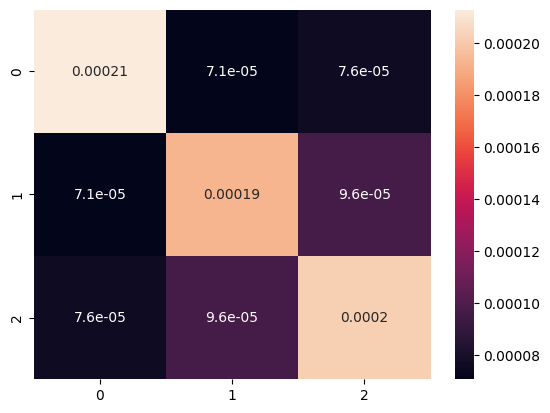

In [ ]:
print("\nCovariance Matrix:")
sns.heatmap(cov_matrix, annot=True)

## **Portfolio Optimization**


In [ ]:
# Define weights as optimization variables
n_assets = len(selected_tickers)
weights = cp.Variable(n_assets)

In [ ]:
# Define portfolio risk (variance) and expected return
risk = cp.quad_form(weights, cov_matrix)
expected_return = weights @ mean_returns

In [ ]:
# Define target return
target_return = 0.0005
# Objective: Minimize risk
objective = cp.Minimize(risk)

In [ ]:
constraints = [
    cp.sum(weights) == 1,
    weights >= 0,
    expected_return >= target_return
]

In [ ]:
# Function to check if the covariance matrix is convex (positive semi-definite)
def is_convex(cov_matrix):
    # Calculate eigenvalues
    eigenvalues = np.linalg.eigvals(cov_matrix)
    # Check if all eigenvalues are non-negative
    return np.all(eigenvalues >= 0)

# Check convexity
if is_convex(cov_matrix):
    print("The covariance matrix is convex (positive semi-definite).")
else:
    print("The covariance matrix is non-convex (not positive semi-definite).")

The covariance matrix is convex (positive semi-definite).


In [ ]:
problem = cp.Problem(objective, constraints)
problem.solve()


0.00012135768388613554

##**Results**


*   **Display the optimal portfolio weights, expected return, and risk**

In [ ]:
print("\nOptimization Results (Convex):")
print("Optimal Weights:", weights.value)
print("Expected Portfolio Return:", expected_return.value)
print("Portfolio Risk (Variance):", problem.value)


Optimization Results (Convex):
Optimal Weights: [0.34485516 0.35179089 0.30335395]
Expected Portfolio Return: 0.0008958696980956685
Portfolio Risk (Variance): 0.00012135768388613554


##**convert covariance matrix to non-convex**

In [ ]:
# Function to convert covariance matrix to non-convex
def convert_to_non_convex(cov_matrix):
    cov_matrix = np.array(cov_matrix)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    modified_eigenvalues = eigenvalues.copy()
    modified_eigenvalues[-1] = -np.abs(modified_eigenvalues[-1])  # Make the smallest eigenvalue negative
    non_convex_matrix = eigenvectors @ np.diag(modified_eigenvalues) @ np.linalg.inv(eigenvectors)
    return non_convex_matrix

In [ ]:
non_convex_cov_matrix = convert_to_non_convex(cov_matrix)


##**Check convexity**

In [ ]:
# Check convexity
if is_convex(non_convex_cov_matrix):
    print("The covariance matrix is convex (positive semi-definite).")
else:
    print("The covariance matrix is non-convex (not positive semi-definite).")

The covariance matrix is non-convex (not positive semi-definite).


##**compute the nearest positive semi-definite matrix**

In [ ]:
# Function to compute the nearest positive semi-definite matrix
def nearest_positive_semi_definite(A, epsilon=1e-6):
  B = (A + A.T) / 2  # Make symmetric
  eigenvalues, eigenvectors = np.linalg.eigh(B)
  eigenvalues[eigenvalues < 0] = 0  # Set negative eigenvalues to 0
  return eigenvectors @ np.diag(eigenvalues + epsilon) @ eigenvectors.T

In [ ]:
regularized_cov_matrix =  nearest_positive_semi_definite(non_convex_cov_matrix)

In [ ]:
weights_non_convex = cp.Variable(n_assets)

##**Define new portfolio risk (variance) and expected return**

In [ ]:
# Define new portfolio risk (variance) and expected return
risk_non_convex = cp.quad_form(weights_non_convex, regularized_cov_matrix)
expected_return_non_convex = weights_non_convex @ mean_returns

##**Objective: Minimize risk for regularized covariance matrix**

In [ ]:
# Objective: Minimize risk for regularized covariance matrix
objective_non_convex = cp.Minimize(risk_non_convex)
constraints_non_convex = [
    cp.sum(weights_non_convex) == 1,
    weights_non_convex >= 0,
    expected_return_non_convex >= target_return
]

##**Solve optimization problem with regularized covariance matrix**

In [ ]:
# Solve optimization problem with regularized covariance matrix
problem_non_convex = cp.Problem(objective_non_convex, constraints_non_convex)
problem_non_convex.solve()


0.00011758063828263169

##**Output results after converting to non-convex covariance matrix**

In [ ]:
# Output results after converting to non-convex covariance matrix
print("\nRegularized Non-Convex Optimization Results: ")
print("Optimal Weights (Regularized):", weights_non_convex.value)
print("Expected Portfolio Return (Regularized):", expected_return_non_convex.value)
print("Portfolio Risk (Variance) (Regularized):", problem_non_convex.value)


Regularized Non-Convex Optimization Results: 
Optimal Weights (Regularized): [ 3.35243059e-01  6.64756941e-01 -3.27926510e-18]
Expected Portfolio Return (Regularized): 0.0008485968559344178
Portfolio Risk (Variance) (Regularized): 0.00011758063828263169


##**back to a convex**

In [ ]:
def convert_to_convex(non_convex_matrix):
    """Convert a non-convex covariance matrix back to a convex (positive semi-definite) matrix."""
    return nearest_positive_semi_definite(non_convex_matrix)

returned_to_convex = convert_to_convex(non_convex_cov_matrix)

##**Return to Check convexity**

In [ ]:
if is_convex(returned_to_convex):
    print("The covariance matrix is convex (positive semi-definite).")
else:
    print("The covariance matrix is non-convex (not positive semi-definite).")


The covariance matrix is convex (positive semi-definite).


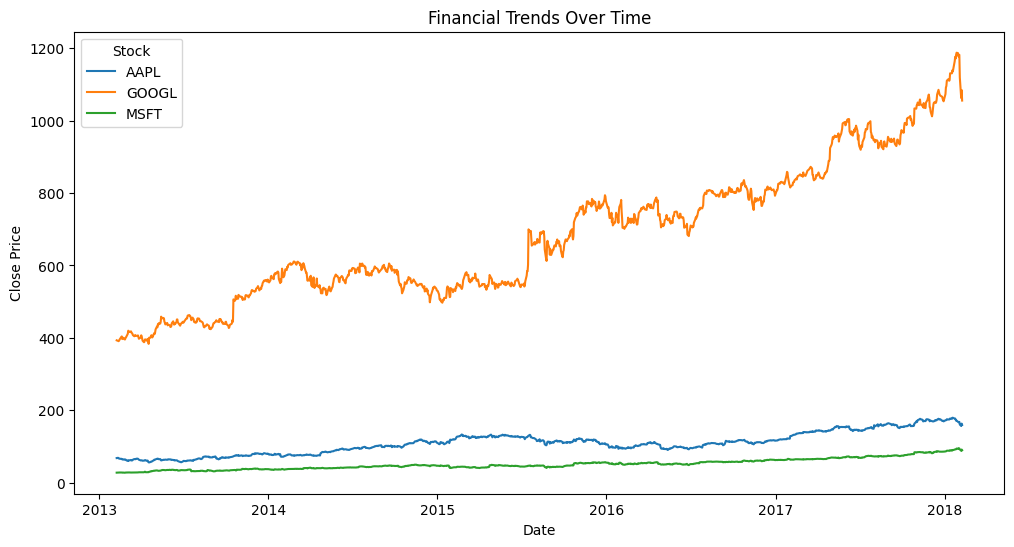

In [ ]:
# I'll assume here, the "close" column represents the Prices (financial trends)..
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='date', y='close', hue='Name')
plt.title('Financial Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Stock')
plt.show()

In [ ]:
portfolio_performance = data.groupby(filtered_data["date"])["close"].sum().to_frame().reset_index()
portfolio_performance

,date,close
0,2013-02-08,488.4819
1,2013-02-11,488.0226
2,2013-02-12,485.4631
3,2013-02-13,486.5670
4,2013-02-14,488.9995
...,...,...
1254,2018-02-01,1443.6300
1255,2018-02-02,1371.4800
1256,2018-02-05,1306.8800
1257,2018-02-06,1338.7900


##**Portfolio Performance Visualization**

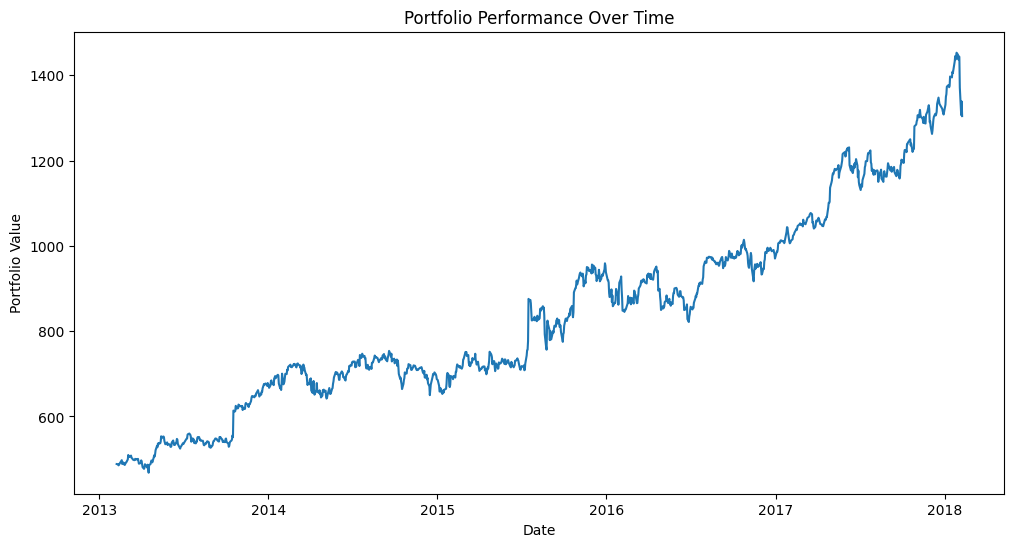

In [ ]:
# Portfolio Performance Visualization..
# I also Assumed here the same..
plt.figure(figsize=(12, 6))
sns.lineplot(data=portfolio_performance, x='date', y='close')
plt.title('Portfolio Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()

In [ ]:
filtered_data.dropna(inplace=True)
filtered_data

,date,open,high,low,close,volume,Name,daily_return
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL,0.010422
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL,-0.025067
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL,-0.001903
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL,-0.000899
1264,2013-02-15,66.9785,67.1656,65.7028,65.7371,97924631,AAPL,-0.013780
...,...,...,...,...,...,...,...,...
391452,2018-02-01,94.7900,96.0700,93.5813,94.2600,47227882,MSFT,-0.007894
391453,2018-02-02,93.6400,93.9700,91.5000,91.7800,47867753,MSFT,-0.026310
391454,2018-02-05,90.5600,93.2400,88.0000,88.0000,51031465,MSFT,-0.041185
391455,2018-02-06,86.8900,91.4750,85.2500,91.3300,67998564,MSFT,0.037841


In [ ]:
# here for getting Return and Risk for (Risk-Return Tradeoff)
risk_return = filtered_data.groupby('Name')['daily_return'].agg(['mean', 'std']).reset_index()
risk_return.columns = ['Stock', 'Return', 'Risk']
risk_return

,Stock,Return,Risk
0,AAPL,0.000786,0.014593
1,GOOGL,0.000880,0.013880
2,MSFT,0.001039,0.014210


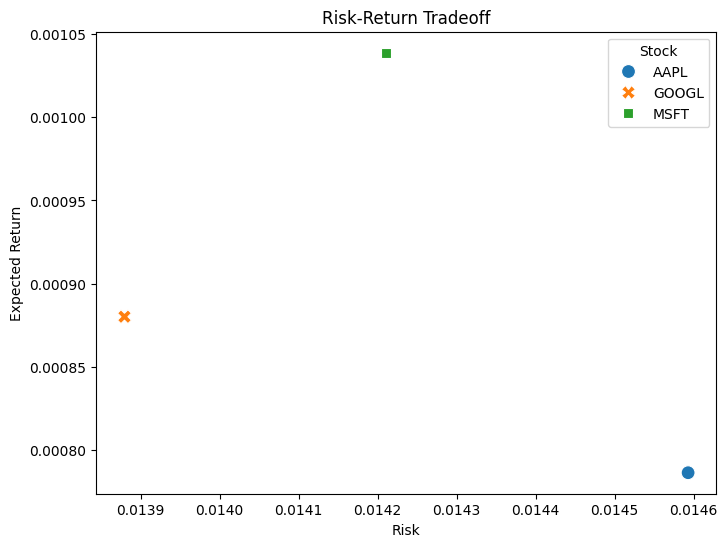

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=risk_return, x='Risk', y='Return', hue='Stock', style='Stock', s=100)
plt.title('Risk-Return Tradeoff')
plt.xlabel('Risk')
plt.ylabel('Expected Return')
plt.show()

In [ ]:
# Creating new Data Frame For Convex and Non-Convex (Return,Risk)..
risk_reutrn_case ={
    'Case': ['Convex','Non-Convex'],
    'Return': [expected_return.value,expected_return_non_convex.value],
    'Risk' : [problem.value,problem_non_convex.value]
}
df = pd.DataFrame(risk_reutrn_case)
df

,Case,Return,Risk
0,Convex,0.000896,0.000121
1,Non-Convex,0.000849,0.000118


##**relationship between risk and return(Convex && NON_Convex)**

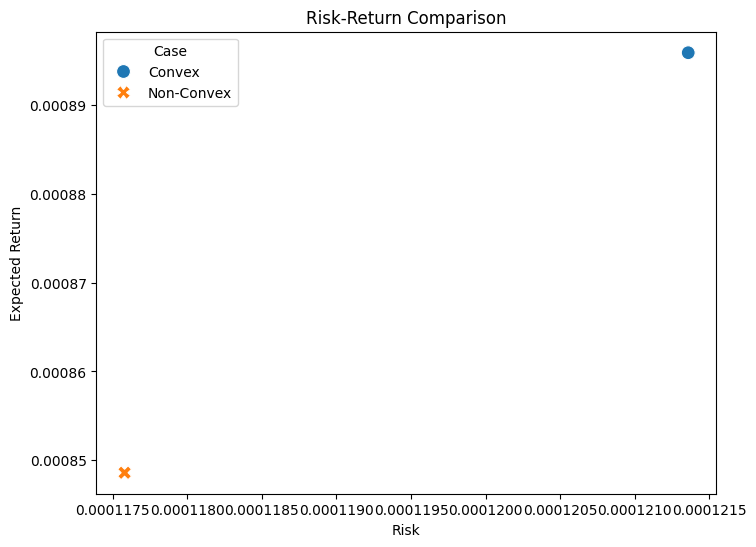

In [ ]:
# relationship between risk and return in the two cases : Convex,Non-Convex
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Risk', y='Return', hue='Case', style='Case', s=100)
plt.title('Risk-Return Comparison')
plt.xlabel('Risk')
plt.ylabel('Expected Return')
plt.show()